In [1]:
## build researcher events, student events, and self-study events
## researcher are simply those with NH citations

In [46]:
import sys

import pandas as pd
import numpy as np
import time
import datetime
import os
from nanoHUB.application import Application
from nanoHUB.configuration import ClusteringConfiguration
from nanoHUB.pipeline.geddes.data import get_default_s3_client
from nanoHUB.dataaccess.lake import S3FileMapper
from nanoHUB.clustering.infra import create_clusters_repository, add_cluster_info, get_all_clustered_users, get_all_self_study_users

In [47]:
pd.set_option('display.max_columns', None)
cwd = os.getcwd()

In [4]:
application = Application.get_instance()
nanohub_db = application.new_db_engine('nanohub')
nanohub_metrics_db = application.new_db_engine('nanohub_metrics')
wang159_myrmekes_db = application.new_db_engine('rfm_data')

s3_client = get_default_s3_client(application)
derived_data_file_path = 'derived_data_for_users.csv'
processed_mapper = S3FileMapper(s3_client, ClusteringConfiguration().bucket_name_processed)

## Cumulative classroom/research/self-study

In [5]:
clustered_df = get_all_clustered_users(processed_mapper, derived_data_file_path)
clustered_df['nanoHUB_user_ID__c'] = clustered_df['id']
clustered_NH_ids = clustered_df['nanoHUB_user_ID__c']
display(len(clustered_NH_ids))

78167

In [6]:
self_study_df = get_all_self_study_users(processed_mapper, derived_data_file_path)
self_study_df['nanoHUB_user_ID__c'] = self_study_df['id']
self_study_NH_ids = self_study_df['nanoHUB_user_ID__c']
display(len(self_study_NH_ids))

194524

In [7]:
print(clustered_NH_ids.shape)
print(self_study_NH_ids.shape)

(78167,)
(194524,)


In [35]:
frames = [clustered_df, self_study_df]
contacts_df = pd.concat(frames)

In [9]:
## need to filter self-study-nh-ids with the researchers

In [10]:
## This researcher determination is based entirely on the results of research authors on nanohub
## i.e., we use the researcher information on db2

In [11]:
sql_query = 'select id, uid, author from jos_citations'
jos_citations = pd.read_sql_query(sql_query, nanohub_db)
display(jos_citations.head(2))
print(jos_citations.shape)

,id,uid,author
0,10000001,5568,"Weber, Bent; Mahapatra, Suddhasatta; Ryu, Hoon..."
1,10000002,5568,"Andrawis, Robert; Bermeo, Jose; Charles, James..."


(4203, 3)


In [12]:
t1_authors = jos_citations['author'].to_list()
t1_authors2 = [] #[j.split(';') for i,j in enumerate(t1_authors)]

In [13]:
for i,j in enumerate(t1_authors):
    try:
        holder = j.split(';')
        if len(holder) > 1: 
            for k,l in enumerate(holder):
                if l[0] == ' ':
                    holder[k] = l[1:]
        t1_authors2.append(holder)
    except:
        garb = True

In [14]:
t1_authors32 = [item for sublist in t1_authors2 for item in sublist]
t1_authors3 = set(t1_authors32)
print(len(t1_authors3))

6860


In [15]:
## extract all researchers with nh ids
rw_ids = []
need_search = []
for i,j in enumerate(t1_authors3):
    if '{{' in j:
        rw_ids.append(i)
    else:
        need_search.append(i)

In [16]:
## from the rw_ids, extract the nanohub userids
# can obtain usernames from the DB2 table
rw_ids2 = np.array(list(t1_authors3))[rw_ids]
for i,j in enumerate(rw_ids2):
    begin = j.index('{{')
    rw_ids2[i] = j[begin+2:-2]
print(len(rw_ids2))

2079


In [17]:
# need to obtain usernames
sql_query = "select id,name,username from jos_users where id in "+str(tuple(rw_ids2))
rw_researchers = pd.read_sql_query(sql_query,nanohub_db)
display(rw_researchers.head(2))

,id,name,username
0,1742,H.-S. Philip Wong,hspwong
1,1767,Osama Munir Nayfeh,onayfeh


In [18]:
## need to obtain the username/ids from those people without nh ids explicitly spec'd in jos_citations
ns2 = np.array(list(t1_authors3))[need_search]
ns2 = ns2[1:]

In [19]:
tuple(ns2)[:5]

('Pranay Baikadi', 'C Bran', 'Arben Merkoci', 'U. Eswaran', 'Cheng-Kok Koh')

In [20]:
sql_query = "select id,name,username from jos_users where name in "+str(tuple(ns2))
ns2_researchers = pd.read_sql_query(sql_query,nanohub_db)
display(ns2_researchers.head(2))

,id,name,username
0,282167,Aarthi Narayanan,aarthin0102
1,280280,Abani Patra,apatra01


In [21]:
## combine the usernames into one data structure
researcher_usernames = rw_researchers['username'].to_list() + ns2_researchers['username'].to_list()
print(len(researcher_usernames))

3046


In [22]:
researcher_track = []

In [23]:
today = datetime.datetime.today()
print(today)

2022-02-19 23:41:08.747375


In [24]:
## caching check 
try:
    user_breakdown_df = pd.read_csv(cwd+'/cached_data/nh_user_breakdown.csv')
    print(user_breakdown_df)
    cache_flag = True
except:
    cache_flag = False

In [25]:
## determine starting year
#if cache_flag == False:
start_year_base = 1999 #2000
#else:
#     print('check the saved file')
#    start_year_base = int(user_breakdown_df['year_month'].to_list()[-1][:4])
    
    

In [26]:
#print(user_breakdown_df['year_month'].to_list()[-1][:4])

In [27]:
from copy import deepcopy

In [28]:
## computer has memory limits, so split toolstart into branches
# this filters and finds the research usage in nanohub
start_year = deepcopy(start_year_base)
while start_year < today.year+1:
    start_year += 1
    end_date = r"'"+str(start_year)+r"-01-01'"
    start_date = r"'"+str(start_year-2)+r"-01-01'"
    
    for i in range(1,13):
        if i < 10:
            start_date = r"'"+str(start_year-1)+r"-0"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-0"+str(i)+r"-01'"
        else:
            start_date = r"'"+str(start_year-1)+r"-"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-"+str(i)+r"-01'"

        sql_query_researcher = "select user from toolstart where user in " + str(tuple(researcher_usernames))\
            +" and datetime <= "+end_date+" and datetime >= "+start_date
        researcher_users = pd.read_sql_query(sql_query_researcher, nanohub_metrics_db)

        researcher_track.append(researcher_users.drop_duplicates().shape[0])

    print('start year: '+ str(start_year))

start year: 2000
start year: 2001
start year: 2002
start year: 2003
start year: 2004
start year: 2005
start year: 2006
start year: 2007
start year: 2008
start year: 2009
start year: 2010
start year: 2011
start year: 2012
start year: 2013
start year: 2014
start year: 2015
start year: 2016
start year: 2017
start year: 2018
start year: 2019
start year: 2020
start year: 2021
start year: 2022
start year: 2023


In [29]:
## filter the self study folks against those of researchers
# need to pull the researcher sf ids

In [30]:
researcher_ids = rw_researchers['id'].to_list() + ns2_researchers['id'].to_list()
print(len(researcher_ids))

3046


In [31]:
bool_search2 = np.in1d(np.array(self_study_NH_ids.tolist()),np.array(researcher_ids))

In [32]:
# Note, researchers can possibly be doubled counted within clusters!!
# sf_researchers = np.where(bool_search2)[0].tolist() 
sf_self_study = np.where(~bool_search2)[0].tolist()

In [33]:
print(len(sf_self_study))
print(len(self_study_NH_ids.to_list()))

192480
194524


In [36]:
sf_contact_ids = contacts_df['nanoHUB_user_ID__c'][sf_self_study]

In [37]:
sf_contact_ids = sf_contact_ids.reset_index()
sf_contact_ids = sf_contact_ids.drop(columns='index')
display(sf_contact_ids)

,nanoHUB_user_ID__c
0,998
1,1000
2,1683
3,1684
4,1685
...,...
192475,237375
192476,237376
192477,237377
192478,237378


In [38]:
tuple(sf_contact_ids['nanoHUB_user_ID__c'])[:5]

(998, 1000, 1683, 1684, 1685)

In [39]:
tuple(self_study_NH_ids.dropna().to_list())[:5]

(998, 1000, 1683, 1684, 1685)

In [40]:
## loading in toolstart

In [41]:
# clustered user usernames
tc_query = 'select id,username from jos_users where id in ' +str(tuple(clustered_NH_ids))
clustered_NH_username = pd.read_sql_query(tc_query,nanohub_db)

In [42]:
# self study user usernames
ts_query = 'select id,username from jos_users where id in ' + str(tuple(self_study_NH_ids.dropna().to_list())) 
#sf_contact_ids['nanoHUB_user_ID__c']))
ss_NH_username = pd.read_sql_query(ts_query,nanohub_db)

In [43]:
## cache the researchers, self-study, and clustered users
cache_r_nhid = pd.DataFrame()
cache_r_nhid['nhid'] = researcher_ids

cache_ss_nhid = pd.DataFrame()
cache_ss_nhid['nhid'] = ss_NH_username['id']
cache_ss_nhid['username'] = ss_NH_username['username']

cache_c_nhid = pd.DataFrame()
cache_c_nhid['nhid'] = clustered_NH_username['id']
cache_c_nhid['username'] = clustered_NH_username['username']

In [44]:
print(cache_r_nhid.head(2))
print(cache_ss_nhid.head(2))
print(cache_c_nhid.head(2))

   nhid
0  1742
1  1767
     nhid username
0  211547  -100005
1  211574  -100024
     nhid    username
0  166284  0.yao.yuan
1  344801  007sribabu


In [48]:
cache_r_nhid.to_csv(cwd+'/cached_data/researcher_ids.csv')
cache_ss_nhid.to_csv(cwd+'/cached_data/ss_ids.csv')
cache_c_nhid.to_csv(cwd+'/cached_data/class_ids.csv')

In [49]:
# clustered_NH_username2;researcher_NH_username2;self_NH_username2
clustered_track = []
self_track = []

# clustered_track_per = []
# self_track_per = []
# researcher_track_per = []

In [50]:
ss_NH_username.shape #old

(194524, 2)

In [51]:
## computer has memory limits, so split toolstart into branches
start_year = deepcopy(start_year_base)

while start_year < today.year+1:
    start_year += 1
    
    for i in range(1,13):
        if i < 10:
            start_date = r"'"+str(start_year-1)+r"-0"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-0"+str(i)+r"-01'"
        else:
            start_date = r"'"+str(start_year-1)+r"-"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-"+str(i)+r"-01'"
        
#         sql_query_clustered = "select user from toolstart where user in " + str(tuple(clustered_NH_username2['username']))\
#             +" and datetime <= "+end_date+" and datetime >= "+start_date
        sql_query_clustered = "select user from toolstart where user in " + str(tuple(clustered_NH_username['username']))\
            +" and datetime <= "+end_date+" and datetime >= "+start_date
        clustered_users = pd.read_sql_query(sql_query_clustered, nanohub_metrics_db)
        
#         sql_query_self = "select user from toolstart where user in " + str(tuple(self_NH_username2['username']))\
#             +" and user != 'instanton' and user != 'gridstat' and datetime <= "+end_date+" and datetime >= "+start_date
        sql_query_self = "select user from toolstart where user in " + str(tuple(ss_NH_username['username']))\
            +" and user != 'instanton' and user != 'gridstat' and datetime <= "+end_date+" and datetime >= "+start_date
        self_users = pd.read_sql_query(sql_query_self, nanohub_metrics_db) #engine_metrics #.drop_duplicates()
        
        clustered_track.append(clustered_users.drop_duplicates().shape[0])
        self_track.append(self_users.drop_duplicates().shape[0])
#         print('start_date: '+start_date)
#         print('end_date: '+end_date)  
    print('start year: '+str(start_year))

start year: 2000
start year: 2001
start year: 2002
start year: 2003
start year: 2004
start year: 2005
start year: 2006
start year: 2007
start year: 2008
start year: 2009
start year: 2010
start year: 2011
start year: 2012
start year: 2013
start year: 2014
start year: 2015
start year: 2016
start year: 2017
start year: 2018
start year: 2019
start year: 2020
start year: 2021
start year: 2022
start year: 2023


In [52]:
all_months_list = list()
for this_year in range(start_year_base+1,today.year+2):
    if cache_flag == True:
        for this_month in range(1,today.month+1):
            all_months_list.append(datetime.datetime(this_year, this_month, 1))
    else:
        for this_month in range(1,12+1):
            all_months_list.append(datetime.datetime(this_year, this_month, 1))

In [53]:
print(len(clustered_track))
print(len(all_months_list))
print(len(researcher_track))

288
288
288


In [54]:
#print(user_breakdown_df2.head())

In [55]:

if cache_flag == True:
    user_breakdown_df2 = pd.DataFrame()
    user_breakdown_df2['year_month'] = all_months_list
    user_breakdown_df2['clustered_track'] = clustered_track
    user_breakdown_df2['self_track'] = self_track
    user_breakdown_df2['researcher_track'] = researcher_track
    
    user_breakdown_df = pd.concat([user_breakdown_df, user_breakdown_df2], ignore_index=True)
    display(user_breakdown_df.head(2))
else:
    user_breakdown_df = pd.DataFrame()
    if today.month == 12:
        user_breakdown_df['year_month'] = all_months_list #months_bin['year_month'].to_list()[13:]
        user_breakdown_df['clustered_track'] = clustered_track#[:len(all_months_list)]
        user_breakdown_df['self_track'] = self_track#[:len(all_months_list)]
        user_breakdown_df['researcher_track'] = researcher_track#[:len(all_months_list)]        
    else:
        user_breakdown_df['year_month'] = all_months_list #-(12-today.month)
        user_breakdown_df['clustered_track'] = clustered_track#[:len(all_months_list[:])]
        user_breakdown_df['self_track'] = self_track#[:len(all_months_list[:])]
        user_breakdown_df['researcher_track'] = researcher_track#[:len(all_months_list[:])]
    display(user_breakdown_df.head(2))

,year_month,clustered_track,self_track,researcher_track
0,2000-01-01,0,0,0
1,2000-02-01,0,0,0


In [56]:
# user_breakdown_df.to_csv(cwd+'/cached_data/temp.csv')

In [57]:
import re

In [58]:
## read the dev_flags.txt to determine where to save
with open(cwd+'/dev_flags.txt','r') as f:
    raw_flags = f.read()
flag_pattern = re.compile(r'= \w+')
flags1 = re.findall(flag_pattern,raw_flags)    
flags_result = [i[2:] for i in flags1]
dev_flag = flags_result[0]
prod_flag = flags_result[1]

[WARNING] [backend_ps - matplotlib.backends.backend_ps]: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque. [backend_ps._is_transparent:303]


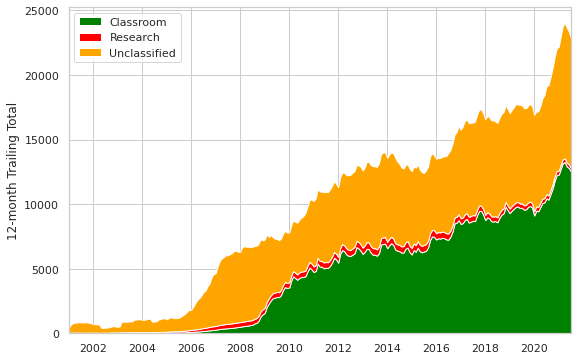

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("whitegrid")

plt.figure(figsize=(9,6))
# user_breakdown_df2 = user_breakdown_df.iloc[:-(12-today.month),:]
user_breakdown_df2 = user_breakdown_df.iloc[:-12-(12-today.month),:]
plt.stackplot(user_breakdown_df2.year_month, \
#               user_breakdown_df2[['clustered_track','self_track']].to_numpy().T, \
#              labels=['Classroom', 'Unclassified'], \
#              colors=['green', 'orange']); #Self-study              
              user_breakdown_df2[['clustered_track', 'researcher_track','self_track']].to_numpy().T, \
             labels=['Classroom','Research', 'Unclassified'], \
             colors=['green', 'red', 'orange']); #Self-study

plt.legend(loc='upper left')#,fontsize=14);
plt.ylabel('12-month Trailing Total')#,fontsize=15)
plt.xlim([datetime.datetime(2001,1,1), datetime.datetime(2021,7,1)])#,fontsize=15)
# plt.show()

if dev_flag == 'True':
    plt.savefig(cwd+'/plots_local/300_simusers_class_res_unclass_12months.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300_simusers_class_res_unclass_12months.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300_simusers_class_res_unclass_12months.png', dpi=1000, bbox_inches='tight')
elif prod_flag == 'True':
    plt.savefig(cwd+'/plots_production/300_simusers_class_res_unclass_12months.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300_simusers_class_res_unclass_12months.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300_simusers_class_res_unclass_12months.png', dpi=1000, bbox_inches='tight')
else:
    print('no printing flag is active')

In [60]:
user_breakdown_df2['clustered_track_per'] = 100*np.divide(user_breakdown_df2['clustered_track'],\
            user_breakdown_df2['clustered_track'].to_numpy()+user_breakdown_df2['researcher_track'].to_numpy()+\
                        user_breakdown_df2['self_track'].to_numpy())
user_breakdown_df2['researcher_track_per'] = 100*np.divide(user_breakdown_df2['researcher_track'],\
            user_breakdown_df2['clustered_track'].to_numpy()+user_breakdown_df2['researcher_track'].to_numpy()+\
                        user_breakdown_df2['self_track'].to_numpy())
user_breakdown_df2['self_track_per'] = 100*np.divide(user_breakdown_df2['self_track'],\
            user_breakdown_df2['clustered_track'].to_numpy()+user_breakdown_df2['researcher_track'].to_numpy()+\
                        user_breakdown_df2['self_track'].to_numpy())

[WARNING] [warnings - py.warnings]: /tmp/ipykernel_1103/3197866797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_breakdown_df2['clustered_track_per'] = 100*np.divide(user_breakdown_df2['clustered_track'],\
 [warnings._showwarnmsg:109]
[WARNING] [warnings - py.warnings]: /tmp/ipykernel_1103/3197866797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_breakdown_df2['researcher_track_per'] = 100*np.divide(user_breakdown_df2['researcher_track'],\
 [warnings._showwarnmsg:109]
[WARNING] [warning

[WARNING] [backend_ps - matplotlib.backends.backend_ps]: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque. [backend_ps._is_transparent:303]


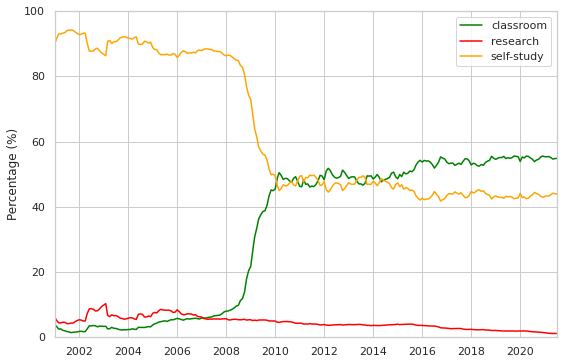

In [61]:
plt.figure(figsize=(9,6))
plt.plot(user_breakdown_df2.year_month, user_breakdown_df2.clustered_track_per, label='classroom', \
             color='green');
plt.plot(user_breakdown_df2.year_month, user_breakdown_df2.researcher_track_per, label='research', \
             color='red');
plt.plot(user_breakdown_df2.year_month, user_breakdown_df2.self_track_per, label='self-study', \
             color='orange');

plt.ylim([0, 100])
plt.legend(loc='upper right');
plt.ylabel('Percentage (%)');
plt.xlim([datetime.datetime(2001,1,1), datetime.datetime(2021,7,1)])
# plt.show()

if dev_flag == 'True':
    plt.savefig(cwd+'/plots_local/300_simusers_class_res_unclass_12months_percent.eps', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300_simusers_class_res_unclass_12months_percent.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/300_simusers_class_res_unclass_12months_percent.png', dpi=300, bbox_inches='tight')
elif prod_flag == 'True':
    plt.savefig(cwd+'/plots_production/300_simusers_class_res_unclass_12months_percent.eps', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300_simusers_class_res_unclass_12months_percent.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/300_simusers_class_res_unclass_12months_percent.png', dpi=300, bbox_inches='tight')
else:
    print('no printing flag is active')

In [62]:
user_breakdown_df2.to_csv(cwd+'/cached_data/nh_user_breakdown.csv')